# Unique Epsilon per Gene

Test the posteriors when using a unique epsilon per gene

# Inputs

In [2]:
import rnaseq_lib3 as r
import pandas as pd
import scipy.stats as st
import pymc3 as pm
import numpy as np
import time
import os
from tqdm import tqdm_notebook as tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Read in centered data
df = pd.read_hdf('/mnt/data/expression/tcga_gtex_tpm_norm_filt.hd5')
# Subset
gtex = df[df.label == 'gtex'].sort_values('tissue')
normal = df[df.label == 'tcga-normal'].sort_values('tissue')
tumor = df[df.label == 'tcga-tumor'].sort_values('tissue')
# Read in drug genes
genes = df.columns[5:]
drug_genes = [x.split('\t')[0] for x in open('../../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]

In [8]:
out_dir = '/mnt/research_serializations/Unique-Epsilon-per-Gene'

# Define Model

In [9]:
def run_unique_eps_model(sample, df, training_genes, group ='tissue', **kwargs):
    classes = sorted(df[group].unique())
    df = df[[group] + training_genes]

    # Collect fits
    ys = {}
    for gene in training_genes:
        for i, dataset in enumerate(classes):
            cat_mu, cat_sd = st.norm.fit(df[df[group] == dataset][gene])
            # Standard deviation can't be initialized to 0, so set to 0.1
            cat_sd = 0.1 if cat_sd == 0 else cat_sd
            ys[f'{gene}={dataset}'] = (cat_mu, cat_sd)

    print('Building model')
    with pm.Model() as model:
        # Linear model priors
        a = pm.Normal('a', mu=0, sd=1)
        b = [1] if len(classes) == 1 else pm.Dirichlet('b', a=np.ones(len(classes)))
        # Model error
        eps = pm.InverseGamma('eps', 2.1, 1, shape=len(training_genes))

        # TODO: Try tt.stack to declare mu more intelligently via b * y
        # Linear model declaration
        for j, gene in tqdm(enumerate(training_genes)):
            mu = a
            for i, dataset in enumerate(classes):
                name = f'{gene}={dataset}'
                y = pm.Normal(name, *ys[name])
                mu += b[i] * y

            # Embed mu in laplacian distribution
            pm.Laplace(gene, mu=mu, b=eps[j], observed=sample[gene])
        # Sample
        trace = pm.sample(**kwargs)
    return model, trace

# Run Model

In [10]:
sample_id = 'TCGA-FC-7961-01'
sample = tumor.loc[sample_id]

ranks = r.outlier.pairwise_distance_ranks(sample, gtex, genes, 'tissue')
training_group = gtex[gtex.tissue.isin(ranks.head(5).Group)]

training_genes = r.outlier.select_k_best_genes(training_group, genes, n=40)
training_genes = list(set(training_genes + drug_genes))
len(training_genes)

125

In [12]:
out = os.path.join(out_dir, f'{sample.id}-drug-genes-40.pkl')
if os.path.exists(out):
    m, t = r.outlier.load_model(out)
else:
    m, t = run_unique_eps_model(sample, training_group, training_genes, 'tissue')
    r.outlier.pickle_model(out, m, t)

Building model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [CSF1R=Prostate, CSF1R=Minor, CSF1R=Cervix, CSF1R=Breast, CSF1R=Bladder, HSP90AB1=Prostate, HSP90AB1=Minor, HSP90AB1=Cervix, HSP90AB1=Breast, HSP90AB1=Bladder, CTD-2314G24.2=Prostate, CTD-2314G24.2=Minor, CTD-2314G24.2=Cervix, CTD-2314G24.2=Breast, CTD-2314G24.2=Bladder, STAT1=Prostate, STAT1=Minor, STAT1=Cervix, STAT1=Breast, STAT1=Bladder, HOXD13=Prostate, HOXD13=Minor, HOXD13=Cervix, HOXD13=Breast, HOXD13=Bladder, TBX15=Prostate, TBX15=Minor, TBX15=Cervix, TBX15=Breast, TBX15=Bladder, SMO=Prostate, SMO=Minor, SMO=Cervix, SMO=Breast, SMO=Bladder, MET=Prostate, MET=Minor, MET=Cervix, MET=Breast, MET=Bladder, HOXB2=Prostate, HOXB2=Minor, HOXB2=Cervix, HOXB2=Breast, HOXB2=Bladder, GLI1=Prostate, GLI1=Minor, GLI1=Cervix, GLI1=Breast, GLI1=Bladder, CCND2=Prostate, CCND2=Minor, CCND2=Cervix, CCND2=Breast, CCND2=Bladder, PDGFRA=Prostate, PDGFRA=Minor, PDGFRA=Cervix, PDGFRA=Breast, PDGFRA=Bladder, RP1-170O19.14=Prostate, RP1-170O19.14=Minor, R

Sampling 4 chains: 100%|██████████| 4000/4000 [39:47<00:00,  1.85s/draws] 
The number of effective samples is smaller than 25% for some parameters.


## Traceplot

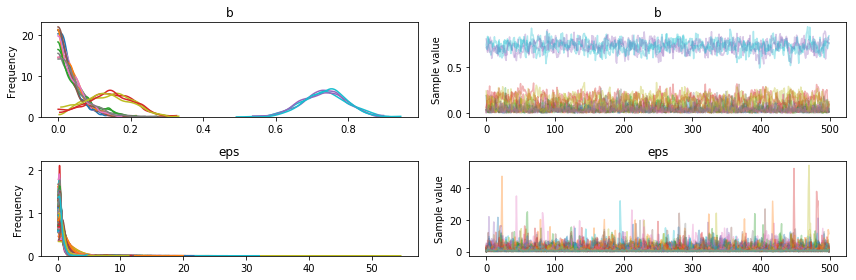

In [17]:
pm.traceplot(t, varnames=['b', 'eps']);

## Weights

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

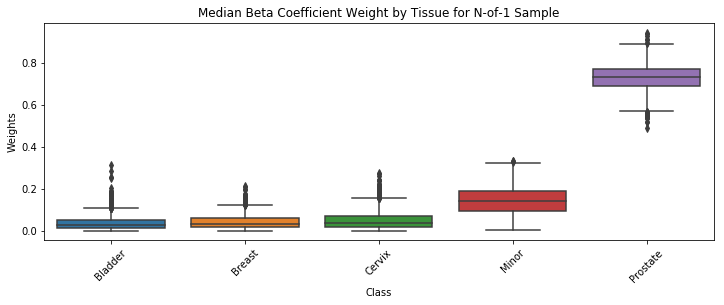

In [15]:
r.outlier.plot_weights(training_group.tissue.unique(), t)
plt.xticks(rotation=45)

## Posterior

In [20]:
ppc = pm.sample_ppc(t, model=m)

100%|██████████| 500/500 [05:21<00:00,  1.55it/s]


In [21]:
#ppc = r.outlier.ppc(t, drug_genes)
ppp = r.outlier.posterior_predictive_pvals(sample, ppc)

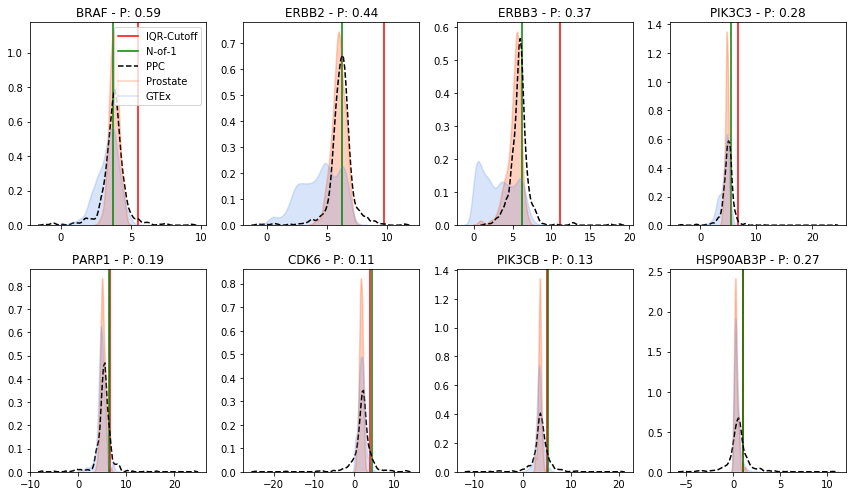

In [22]:
candidates = ['BRAF', 'ERBB2', 'ERBB3', 'PIK3C3', 'PARP1', 'CDK6', 'PIK3CB', 'HSP90AB3P']

f, ax = plt.subplots(2, 4, figsize=(12, 7))
ax = ax.flatten()
for i, gene in enumerate(candidates):
    _, upper = r.math.iqr_bounds(gtex[gene])
    ax[i].axvline(upper, c='r', label='IQR-Cutoff')
    ax[i].axvline(sample[gene], c='g', label='N-of-1')
    sns.kdeplot(ppc[gene], label='PPC', ax=ax[i], ls='--', c='k')
    sns.kdeplot(gtex[gtex.tissue == 'Prostate'][gene], ax=ax[i], shade=True, alpha=0.25, label='Prostate', c='orangered')
    sns.kdeplot(gtex[gene], label='GTEx', ax=ax[i], shade=True, alpha=0.25, c='cornflowerblue')
    ax[i].set_title(f'{gene} - P: {round(ppp[gene], 2)}')
    if i != 0:
        ax[i].get_legend().remove()
plt.tight_layout()